In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv
/kaggle/input/global-weather-repository/state.db


In [2]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Step 2: Load and explore the dataset
df = pd.read_csv("/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv")

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
display(df.head())

Dataset Shape: (104453, 41)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104453 entries, 0 to 104452
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   country                       104453 non-null  object 
 1   location_name                 104453 non-null  object 
 2   latitude                      104453 non-null  float64
 3   longitude                     104453 non-null  float64
 4   timezone                      104453 non-null  object 
 5   last_updated_epoch            104453 non-null  int64  
 6   last_updated                  104453 non-null  object 
 7   temperature_celsius           104453 non-null  float64
 8   temperature_fahrenheit        104453 non-null  float64
 9   condition_text                104453 non-null  object 
 10  wind_mph                      104453 non-null  float64
 11  wind_kph                      104453 non-null  float64
 12  w

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [4]:
# Step 3: Data Preprocessing
# Convert date and create time-based features
df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
df['date'] = df['last_updated'].dt.date
df['year'] = df['last_updated'].dt.year
df['month'] = df['last_updated'].dt.month
df['day'] = df['last_updated'].dt.day
df['day_of_week'] = df['last_updated'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Remove duplicates
df = df.drop_duplicates(subset=['country', 'location_name', 'date']).reset_index(drop=True)

# Check for missing values
print("Missing Values Summary:")
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percentage (%)': missing_percent})
display(missing_df.head(15))

# Handle missing values - drop columns with too many missing values and impute others
cols_to_drop = missing_df[missing_df['Percentage (%)'] > 30].index.tolist()
print(f"\nDropping columns with >30% missing values: {cols_to_drop}")

df_clean = df.drop(columns=cols_to_drop)

# Fill remaining missing values
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

print(f"\nShape after cleaning: {df_clean.shape}")

Missing Values Summary:


,Missing Count,Percentage (%)
country,0,0.0
sunrise,0,0.0
gust_kph,0,0.0
air_quality_Carbon_Monoxide,0,0.0
air_quality_Ozone,0,0.0
air_quality_Nitrogen_dioxide,0,0.0
air_quality_Sulphur_dioxide,0,0.0
air_quality_PM2.5,0,0.0
air_quality_PM10,0,0.0
air_quality_us-epa-index,0,0.0



Dropping columns with >30% missing values: []

Shape after cleaning: (104209, 47)


In [5]:
# Step 4: Create target variable - Next day PM2.5
df_clean = df_clean.sort_values(['country', 'location_name', 'date'])

# Create next day PM2.5 target
df_clean['next_day_PM2.5'] = df_clean.groupby(['country', 'location_name'])['air_quality_PM2.5'].shift(-1)

# Remove rows where target is missing
df_clean = df_clean.dropna(subset=['next_day_PM2.5'])

print(f"Shape after creating target variable: {df_clean.shape}")
print(f"Target variable range: {df_clean['next_day_PM2.5'].min():.2f} to {df_clean['next_day_PM2.5'].max():.2f}")

Shape after creating target variable: (103942, 48)
Target variable range: 0.17 to 1614.10


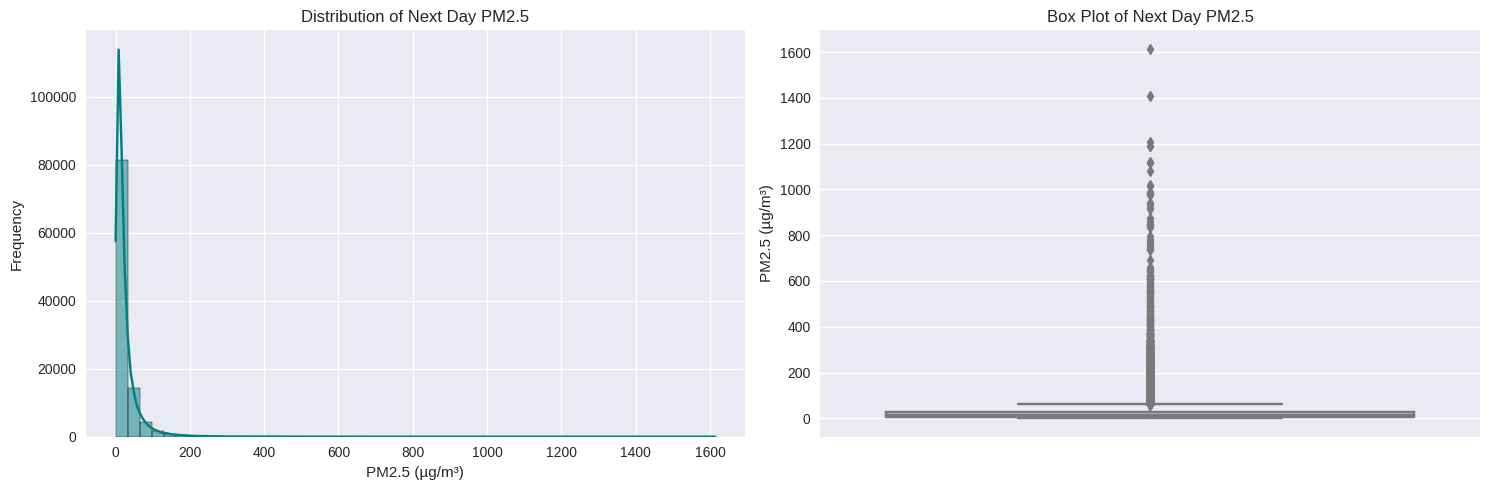

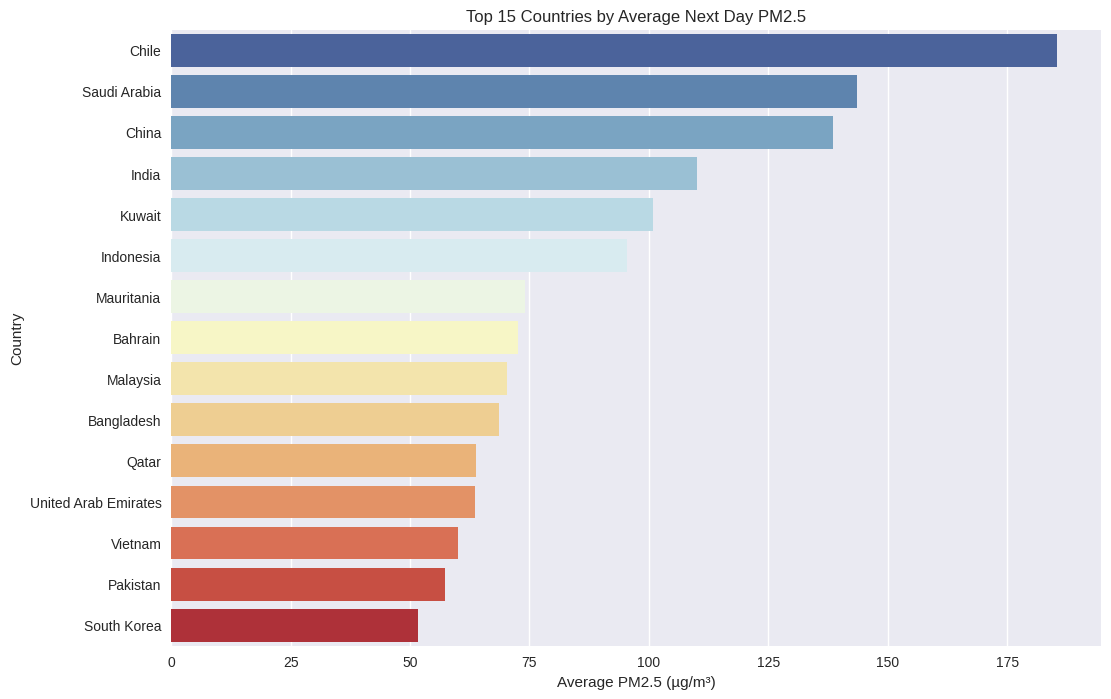

In [6]:
# Step 5: Exploratory Data Analysis
# 5.1 Distribution of target variable
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['next_day_PM2.5'], bins=50, kde=True, color='teal')
plt.title('Distribution of Next Day PM2.5')
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['next_day_PM2.5'], color='lightblue')
plt.title('Box Plot of Next Day PM2.5')
plt.ylabel('PM2.5 (µg/m³)')

plt.tight_layout()
plt.show()

# 5.2 Top countries by average PM2.5
top_countries_pm25 = df_clean.groupby('country')['next_day_PM2.5'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_countries_pm25.values, y=top_countries_pm25.index, palette='RdYlBu_r')
plt.title('Top 15 Countries by Average Next Day PM2.5')
plt.xlabel('Average PM2.5 (µg/m³)')
plt.ylabel('Country')
plt.show()

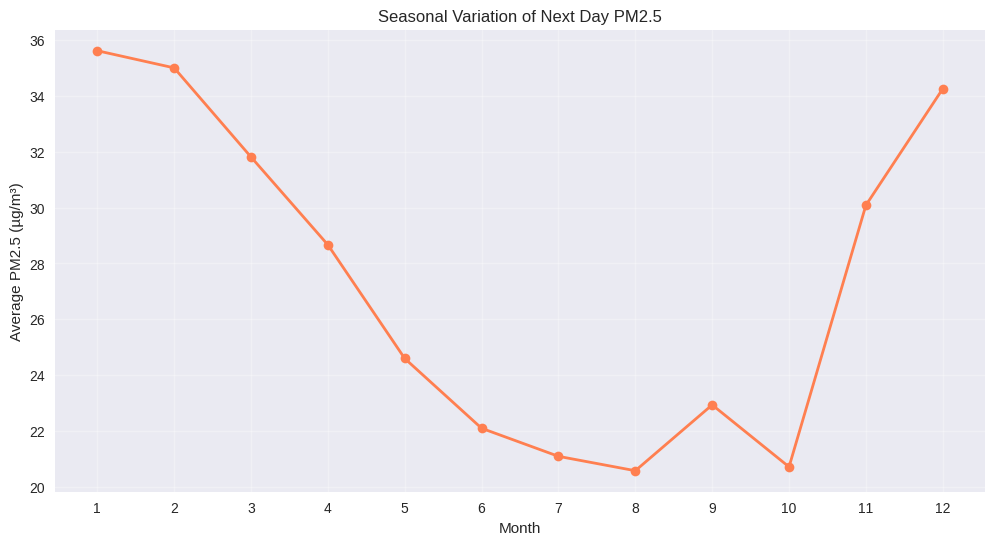

In [7]:
# 5.3 Seasonal analysis of PM2.5
monthly_pm25 = df_clean.groupby('month')['next_day_PM2.5'].mean()

plt.figure(figsize=(12, 6))
monthly_pm25.plot(kind='line', marker='o', color='coral', linewidth=2)
plt.title('Seasonal Variation of Next Day PM2.5')
plt.xlabel('Month')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.show()

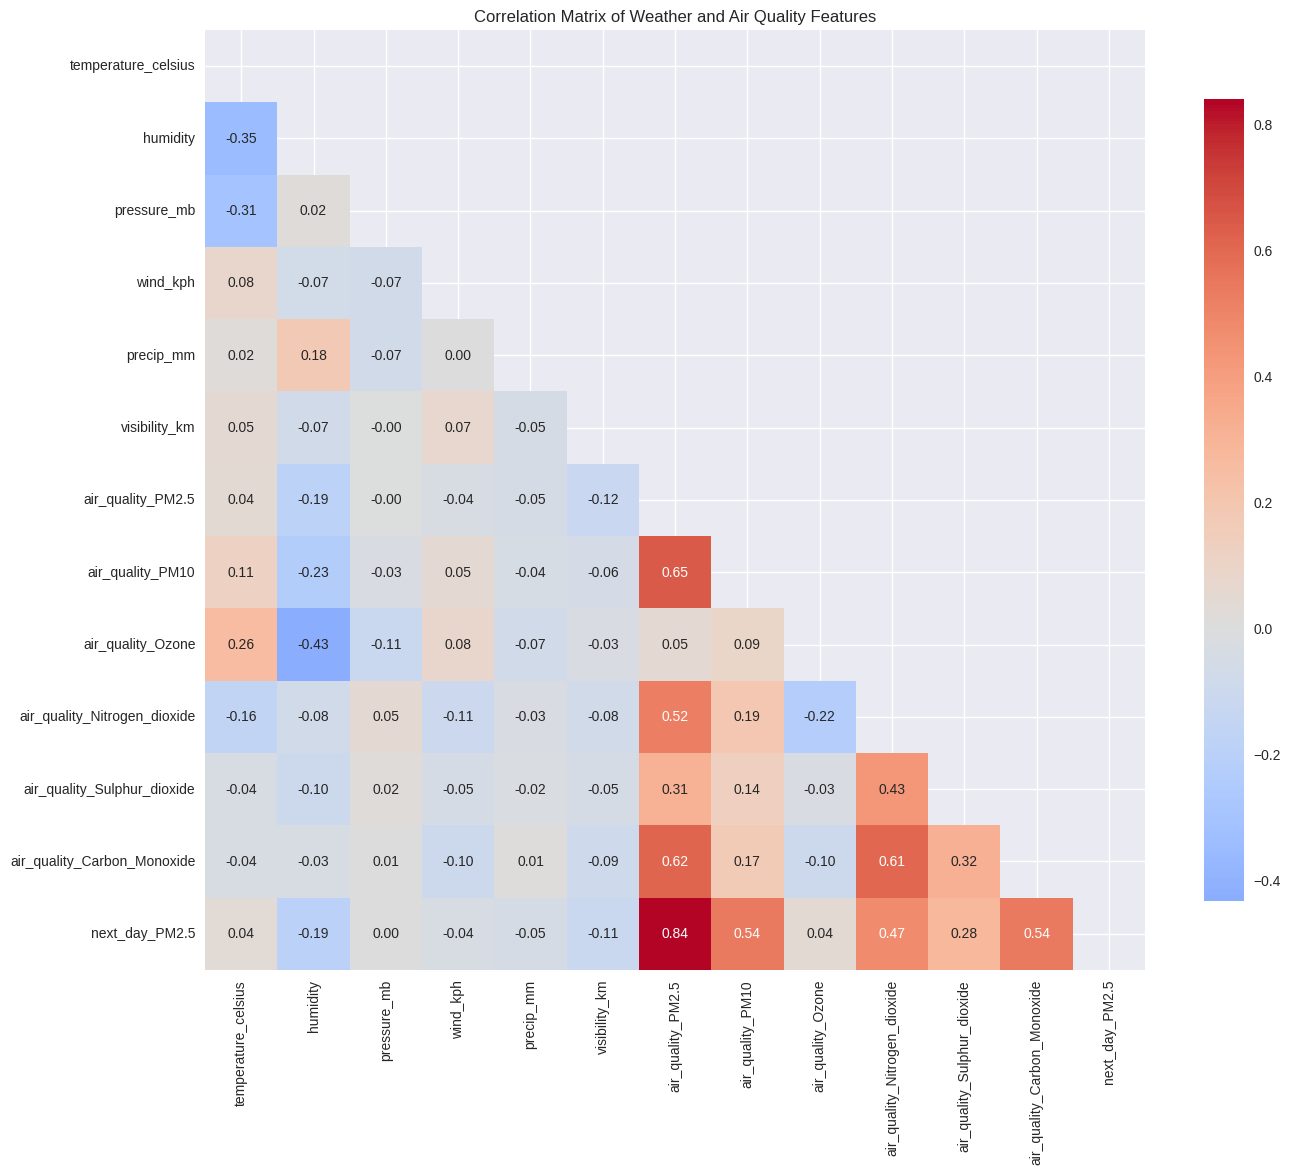

In [8]:
# 5.4 Correlation heatmap
# Select relevant features for correlation analysis
correlation_features = [
    'temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 
    'precip_mm', 'visibility_km', 'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 
    'air_quality_Sulphur_dioxide', 'air_quality_Carbon_Monoxide',
    'next_day_PM2.5'
]

corr_matrix = df_clean[correlation_features].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Weather and Air Quality Features')
plt.tight_layout()
plt.show()

In [9]:
# Step 6: Feature Engineering
# 6.1 Select features for modeling
feature_columns = [
    'temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph',
    'precip_mm', 'visibility_km', 'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
    'air_quality_Sulphur_dioxide', 'air_quality_Carbon_Monoxide',
    'month', 'day_of_week', 'is_weekend'
]

# 6.2 Encode categorical variables
le_country = LabelEncoder()
df_clean['country_encoded'] = le_country.fit_transform(df_clean['country'])

le_location = LabelEncoder()
df_clean['location_encoded'] = le_location.fit_transform(df_clean['location_name'])

# Add encoded location features
feature_columns.extend(['country_encoded', 'location_encoded'])

# 6.3 Create feature matrix and target vector
X = df_clean[feature_columns]
y = df_clean['next_day_PM2.5']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# 6.4 Handle outliers in target variable
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (y >= lower_bound) & (y <= upper_bound)
X_clean = X[outlier_mask]
y_clean = y[outlier_mask]

print(f"Shape after removing outliers: {X_clean.shape}")
print(f"Percentage of data retained: {len(X_clean)/len(X)*100:.2f}%")

Feature matrix shape: (103942, 17)
Target vector shape: (103942,)
Shape after removing outliers: (95076, 17)
Percentage of data retained: 91.47%


In [10]:
# Step 7: Train-Test Split and Scaling
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, shuffle=False
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 76060
Test set size: 19016


In [11]:
# Step 8: Model Development
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Dictionary to store results
results = {}

# Train and evaluate models
for name, model in models.items():
    if name in ['SVR']:
        # SVR requires scaled data
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'Model': model,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Predictions': y_pred
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-" * 50)

Linear Regression:
  RMSE: 9.7052
  MAE: 6.8813
  R²: 0.5035
--------------------------------------------------
Random Forest:
  RMSE: 8.8431
  MAE: 6.3565
  R²: 0.5877
--------------------------------------------------
Gradient Boosting:
  RMSE: 8.6075
  MAE: 5.9873
  R²: 0.6094
--------------------------------------------------
XGBoost:
  RMSE: 9.9760
  MAE: 6.9492
  R²: 0.4754
--------------------------------------------------
SVR:
  RMSE: 8.6992
  MAE: 6.0515
  R²: 0.6011
--------------------------------------------------


In [13]:
# Step 9: Model Comparison and Selection
# Create comparison table
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[model]['RMSE'] for model in results],
    'MAE': [results[model]['MAE'] for model in results],
    'R²': [results[model]['R²'] for model in results]
}).sort_values('RMSE')

print("Model Performance Comparison:")
display(results_df)

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['Model']
best_predictions = results[best_model_name]['Predictions']

print(f"\nBest Model: {best_model_name}")

Model Performance Comparison:


,Model,RMSE,MAE,R²
2,Gradient Boosting,8.607536,5.987339,0.609420
4,SVR,8.699182,6.051479,0.601058
1,Random Forest,8.843118,6.356464,0.587747
0,Linear Regression,9.705164,6.881306,0.503455
3,XGBoost,9.976024,6.949152,0.475352



Best Model: Gradient Boosting


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
if best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print(f"Best parameters for {best_model_name}: {grid_search.best_params_}")

    final_predictions = best_model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
    final_mae = mean_absolute_error(y_test, final_predictions)
    final_r2 = r2_score(y_test, final_predictions)

    print("\nFinal Performance after Tuning:")
    print(f"RMSE: {final_rmse:.4f}")
    print(f"MAE : {final_mae:.4f}")
    print(f"R²  : {final_r2:.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Final Performance after Tuning:
RMSE: 8.6123
MAE : 5.9449
R²  : 0.6090


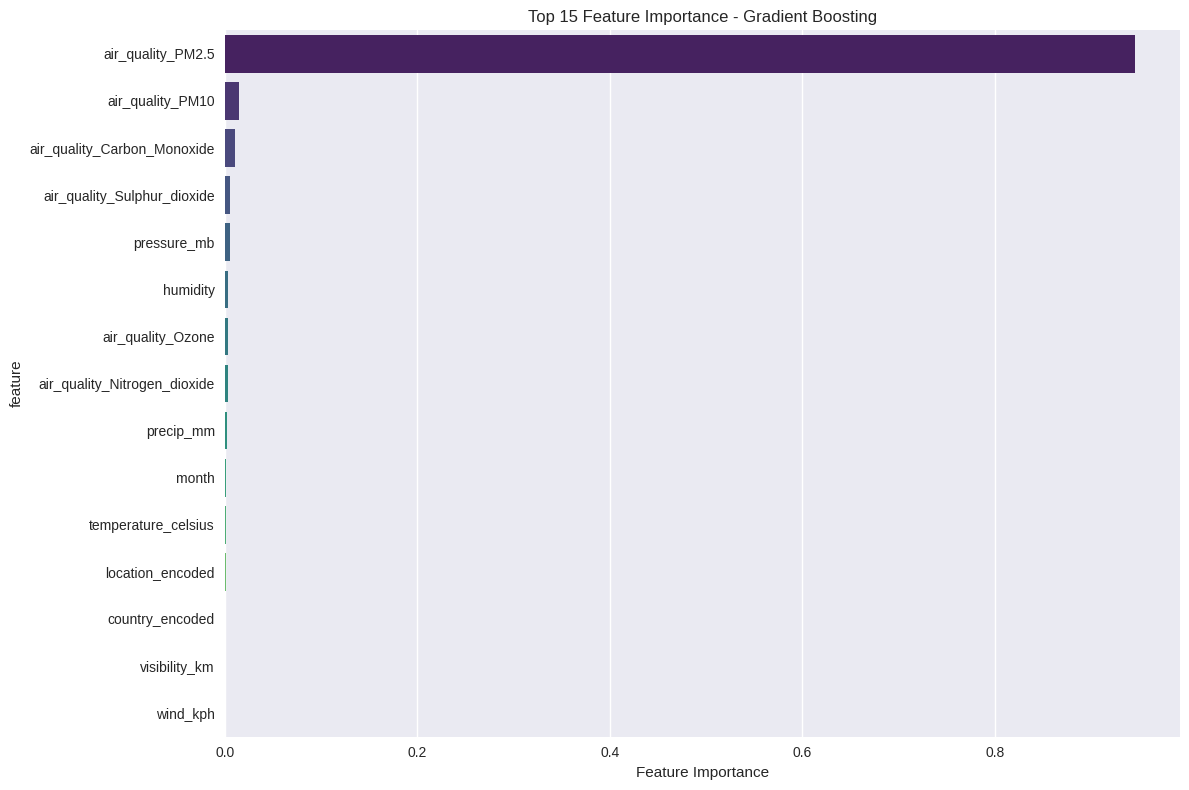

Top 10 Most Important Features:


,feature,importance
6,air_quality_PM2.5,0.944895
7,air_quality_PM10,0.014701
11,air_quality_Carbon_Monoxide,0.011048
10,air_quality_Sulphur_dioxide,0.005760
2,pressure_mb,0.005591
1,humidity,0.003787
8,air_quality_Ozone,0.003349
9,air_quality_Nitrogen_dioxide,0.003186
4,precip_mm,0.002493
12,month,0.001761


In [19]:
# Step 11: Feature Importance Analysis
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    display(feature_importance.head(10))

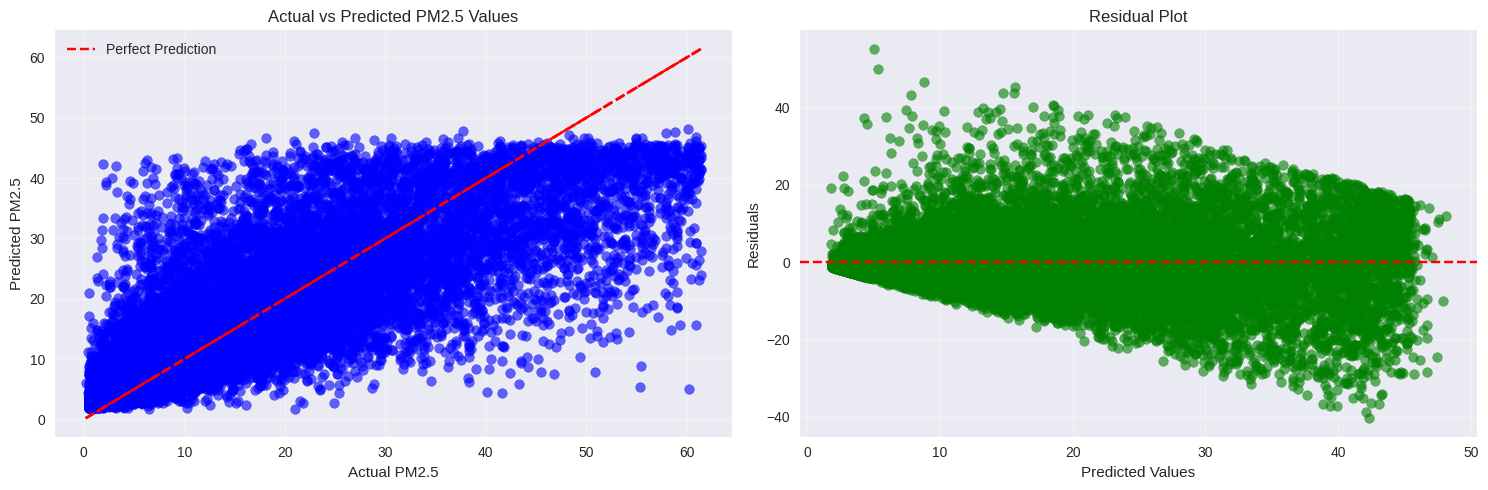

In [20]:
# Step 12: Visualization of Results
# 12.1 Actual vs Predicted values
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, final_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 Values')
plt.grid(True, alpha=0.3)

# Add perfect prediction line
max_val = max(y_test.max(), final_predictions.max())
min_val = min(y_test.min(), final_predictions.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
plt.legend()

# 12.2 Residual plot
residuals = y_test - final_predictions
plt.subplot(1, 2, 2)
plt.scatter(final_predictions, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

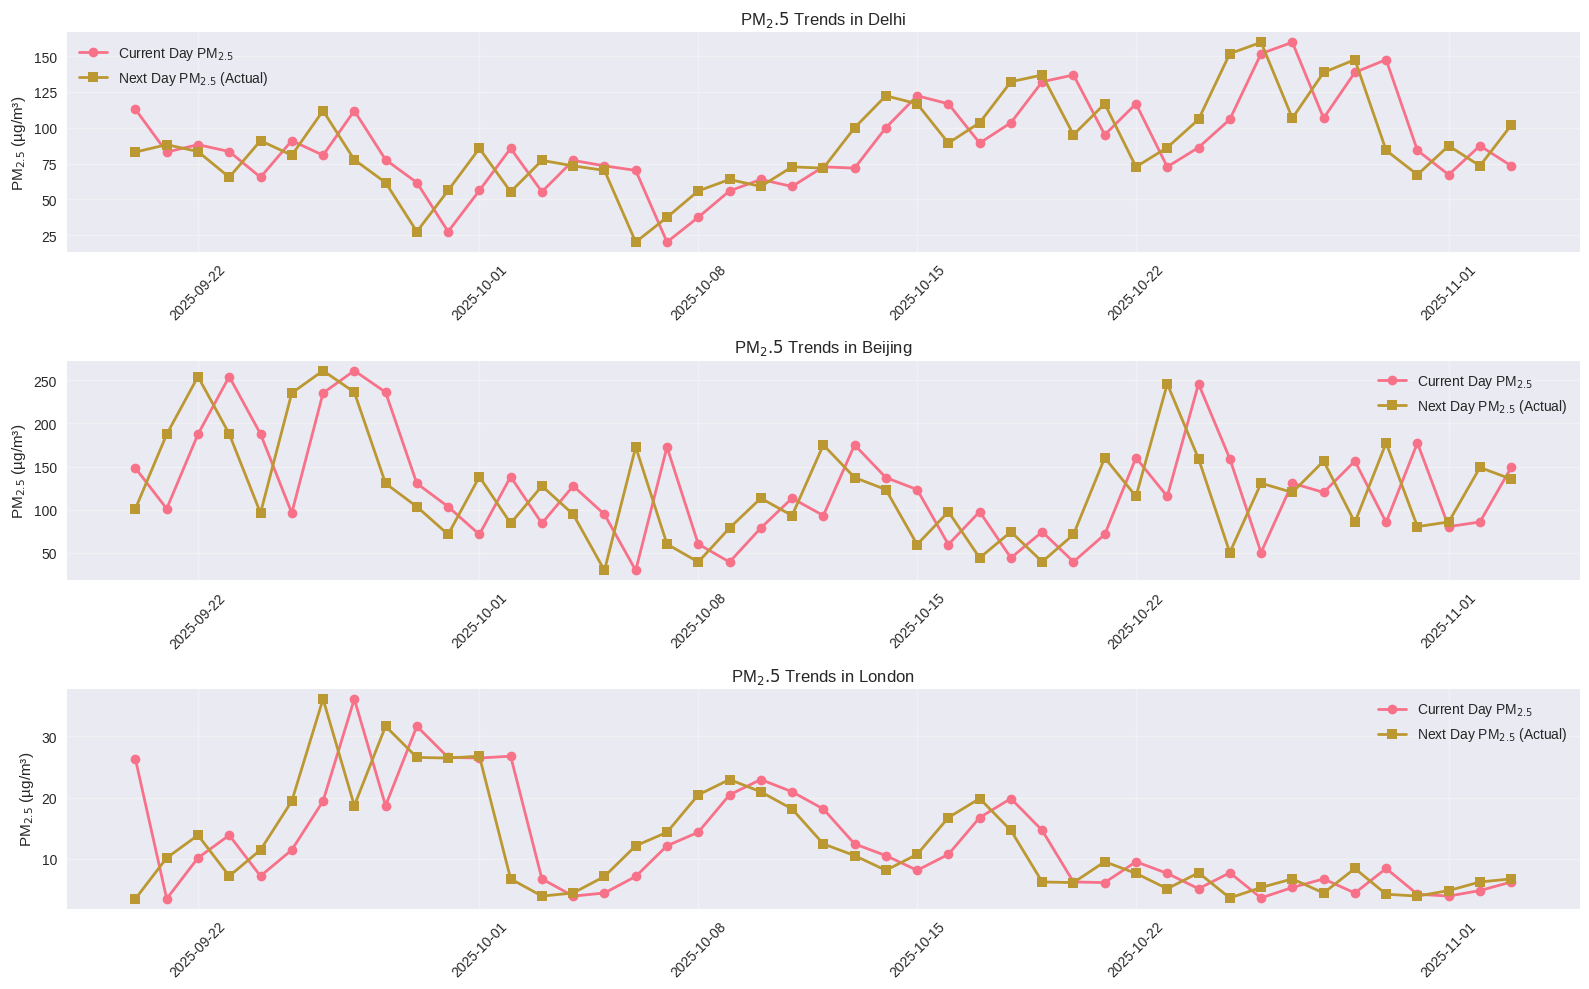

In [28]:
import matplotlib.pyplot as plt

def plot_time_series_multiple(locations, num_days=30):
    plt.figure(figsize=(16, 10))
    n = len(locations)

    for i, loc in enumerate(locations, 1):
        location_data = df_clean[df_clean['location_name'].str.contains(loc, case=False)].tail(num_days)
        if len(location_data) == 0:
            print(f"No data found for: {loc}")
            continue

        plt.subplot(n, 1, i)
        plt.plot(location_data['date'], location_data['air_quality_PM2.5'],
                 marker='o', label='Current Day PM$_{2.5}$', linewidth=2)
        plt.plot(location_data['date'], location_data['next_day_PM2.5'],
                 marker='s', label='Next Day PM$_{2.5}$ (Actual)', linewidth=2)
        plt.title(f'PM$_{2.5}$ Trends in {loc}')
        plt.ylabel('PM$_{2.5}$ (µg/m³)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example for multiple major cities
plot_time_series_multiple(['Delhi', 'Beijing', 'London'], num_days=45)


Model Performance by PM2.5 Category:


,PM2.5 Category,Classification Accuracy
1,Moderate (12.1-35.4),0.791891
0,Good (0-12),0.722001
2,Unhealthy for Sensitive (35.5-55.4),0.463061
3,Unhealthy (55.5-150.4),0.000000


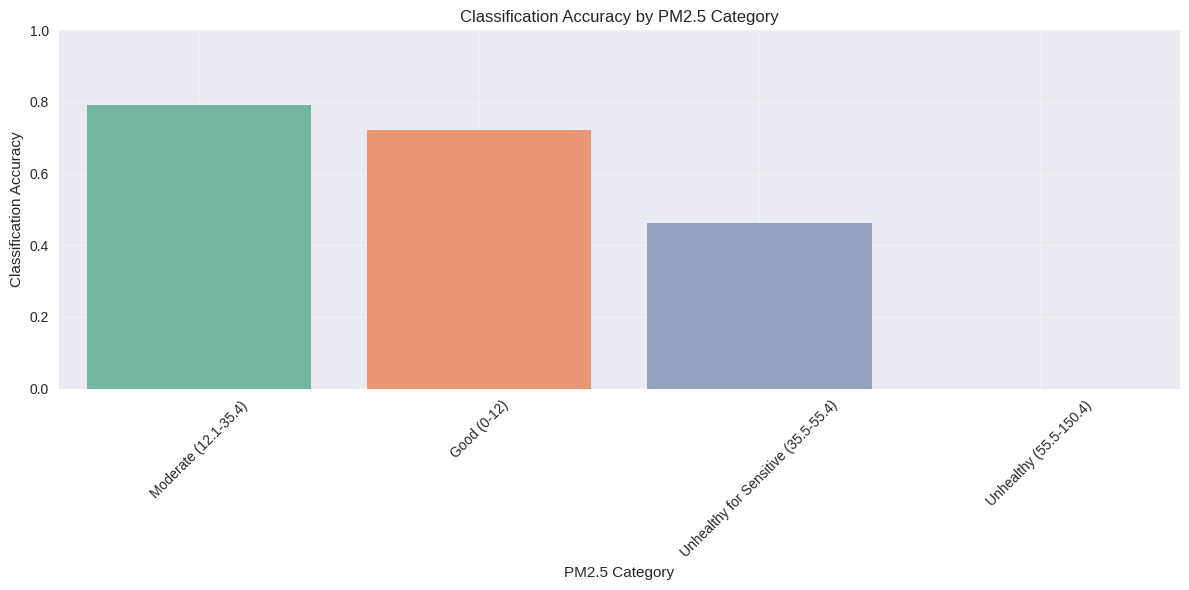

In [30]:
# Step 13: Model Performance by PM2.5 Levels
# Categorize PM2.5 levels
def categorize_pm25(pm25):
    if pm25 <= 12:
        return 'Good (0-12)'
    elif pm25 <= 35.4:
        return 'Moderate (12.1-35.4)'
    elif pm25 <= 55.4:
        return 'Unhealthy for Sensitive (35.5-55.4)'
    elif pm25 <= 150.4:
        return 'Unhealthy (55.5-150.4)'
    else:
        return 'Very Unhealthy (>150.4)'

# Add categories to test set
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': final_predictions
})
test_results['Actual_Category'] = test_results['Actual'].apply(categorize_pm25)
test_results['Predicted_Category'] = test_results['Predicted'].apply(categorize_pm25)

# Calculate accuracy by category
category_accuracy = {}
for category in test_results['Actual_Category'].unique():
    category_data = test_results[test_results['Actual_Category'] == category]
    accuracy = (category_data['Actual_Category'] == category_data['Predicted_Category']).mean()
    category_accuracy[category] = accuracy

category_acc_df = pd.DataFrame({
    'PM2.5 Category': category_accuracy.keys(),
    'Classification Accuracy': category_accuracy.values()
}).sort_values('Classification Accuracy', ascending=False)

print("Model Performance by PM2.5 Category:")
display(category_acc_df)

# Plot category-wise performance
plt.figure(figsize=(12, 6))
sns.barplot(data=category_acc_df, x='PM2.5 Category', y='Classification Accuracy', palette='Set2')
plt.title('Classification Accuracy by PM2.5 Category')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# Step 14: Cross-Validation Results
def perform_cross_validation(model, X, y, cv=5):
    scores_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores_rmse = np.sqrt(-scores_rmse)
    scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
    
    return {
        'RMSE_mean': scores_rmse.mean(),
        'RMSE_std': scores_rmse.std(),
        'R2_mean': scores_r2.mean(),
        'R2_std': scores_r2.std()
    }

# Perform cross-validation for best model
cv_results = perform_cross_validation(best_model, X_clean, y_clean, cv=5)

print("Cross-Validation Results for Best Model:")
print(f"RMSE: {cv_results['RMSE_mean']:.4f} (±{cv_results['RMSE_std']:.4f})")
print(f"R²: {cv_results['R2_mean']:.4f} (±{cv_results['R2_std']:.4f})")

Cross-Validation Results for Best Model:
RMSE: 8.0816 (±0.3249)
R²: 0.6521 (±0.0244)


In [32]:
# Step 15: Final Model Summary and Export
final_summary = {
    'Best Model': best_model_name,
    'Final RMSE': final_rmse,
    'Final MAE': final_mae,
    'Final R²': final_r2,
    'CV RMSE': cv_results['RMSE_mean'],
    'CV R²': cv_results['R2_mean'],
    'Number of Features': len(feature_columns),
    'Training Samples': X_train.shape[0],
    'Test Samples': X_test.shape[0]
}

summary_df = pd.DataFrame([final_summary]).T
summary_df.columns = ['Value']
print("FINAL MODEL SUMMARY")
print("="*50)
display(summary_df)

# Save model predictions for further analysis
final_results = pd.DataFrame({
    'Actual_PM2.5': y_test,
    'Predicted_PM2.5': final_predictions,
    'Residuals': residuals
})

# Save to CSV
final_results.to_csv('pm25_predictions_results.csv', index=False)
print("\nPredictions saved to 'pm25_predictions_results.csv'")

FINAL MODEL SUMMARY


,Value
Best Model,Gradient Boosting
Final RMSE,8.612281
Final MAE,5.944932
Final R²,0.608989
CV RMSE,8.081556
CV R²,0.652092
Number of Features,17
Training Samples,76060
Test Samples,19016



Predictions saved to 'pm25_predictions_results.csv'


Model Performance by Country (Top 10):


,Country,Samples,RMSE,R²,Avg_PM2.5
20,Tuvalu,535,3.581427,0.439625,6.556479
15,Tonga,523,3.665990,0.630439,9.450956
14,Timor-Leste,532,3.852080,0.507236,8.394445
12,Tanzania,535,3.866014,0.631654,9.504206
28,Vanuatu,530,4.056362,0.545891,9.859943
0,Somalia,468,4.781026,0.583343,14.048248
6,Suriname,532,4.916826,0.580398,9.430912
8,Sweden,534,5.257851,0.045622,7.400833
16,Trinidad and Tobago,532,5.539427,0.474136,10.148536
25,United States of America,524,5.725299,-0.204446,6.387366


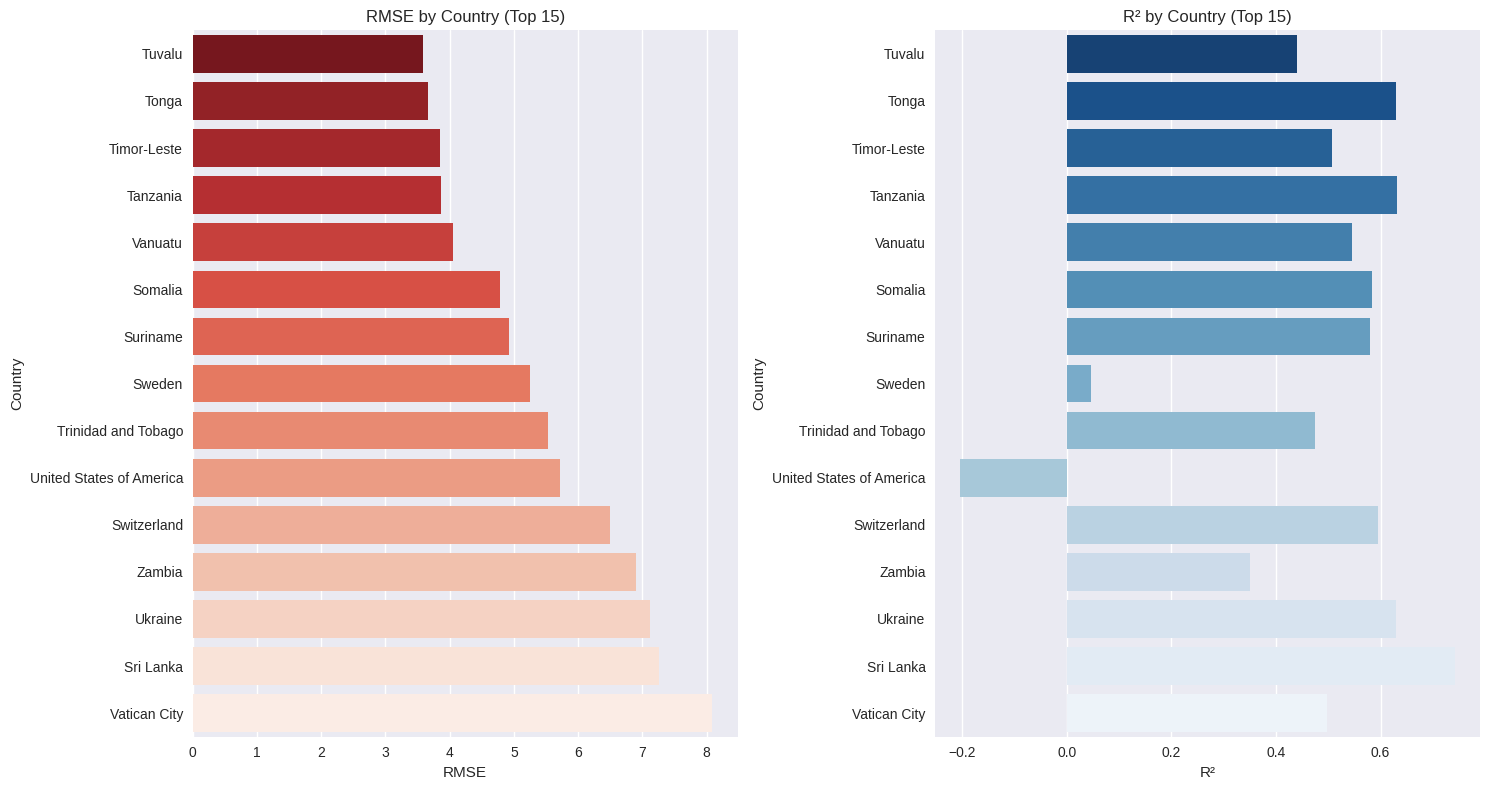

In [33]:
# Step 16: Additional Analysis - Geographical Patterns
# Analyze model performance by country
country_performance = []
for country in df_clean['country'].unique():
    country_mask = (df_clean['country'] == country) & (df_clean.index.isin(X_test.index))
    if country_mask.sum() > 10:  # Only consider countries with sufficient test data
        country_actual = y_test[df_clean.loc[X_test.index]['country'] == country]
        country_pred = final_predictions[df_clean.loc[X_test.index]['country'] == country]
        
        if len(country_actual) > 0:
            country_rmse = np.sqrt(mean_squared_error(country_actual, country_pred))
            country_r2 = r2_score(country_actual, country_pred)
            
            country_performance.append({
                'Country': country,
                'Samples': len(country_actual),
                'RMSE': country_rmse,
                'R²': country_r2,
                'Avg_PM2.5': country_actual.mean()
            })

country_perf_df = pd.DataFrame(country_performance).sort_values('RMSE')
print("Model Performance by Country (Top 10):")
display(country_perf_df.head(10))

# Plot country-wise performance
plt.figure(figsize=(15, 8))
top_countries = country_perf_df.head(15)

plt.subplot(1, 2, 1)
sns.barplot(data=top_countries, x='RMSE', y='Country', palette='Reds_r')
plt.title('RMSE by Country (Top 15)')
plt.xlabel('RMSE')

plt.subplot(1, 2, 2)
sns.barplot(data=top_countries, x='R²', y='Country', palette='Blues_r')
plt.title('R² by Country (Top 15)')
plt.xlabel('R²')

plt.tight_layout()
plt.show()

Model Performance by Country (R² ≥ 0, Top 10):


,Country,Samples,RMSE,R²,Avg_PM2.5
0,Tuvalu,535,3.581427,0.439625,6.556479
1,Tonga,523,3.665990,0.630439,9.450956
2,Timor-Leste,532,3.852080,0.507236,8.394445
3,Tanzania,535,3.866014,0.631654,9.504206
4,Vanuatu,530,4.056362,0.545891,9.859943
5,Somalia,468,4.781026,0.583343,14.048248
6,Suriname,532,4.916826,0.580398,9.430912
7,Sweden,534,5.257851,0.045622,7.400833
8,Trinidad and Tobago,532,5.539427,0.474136,10.148536
9,Switzerland,557,6.498935,0.595465,13.235163


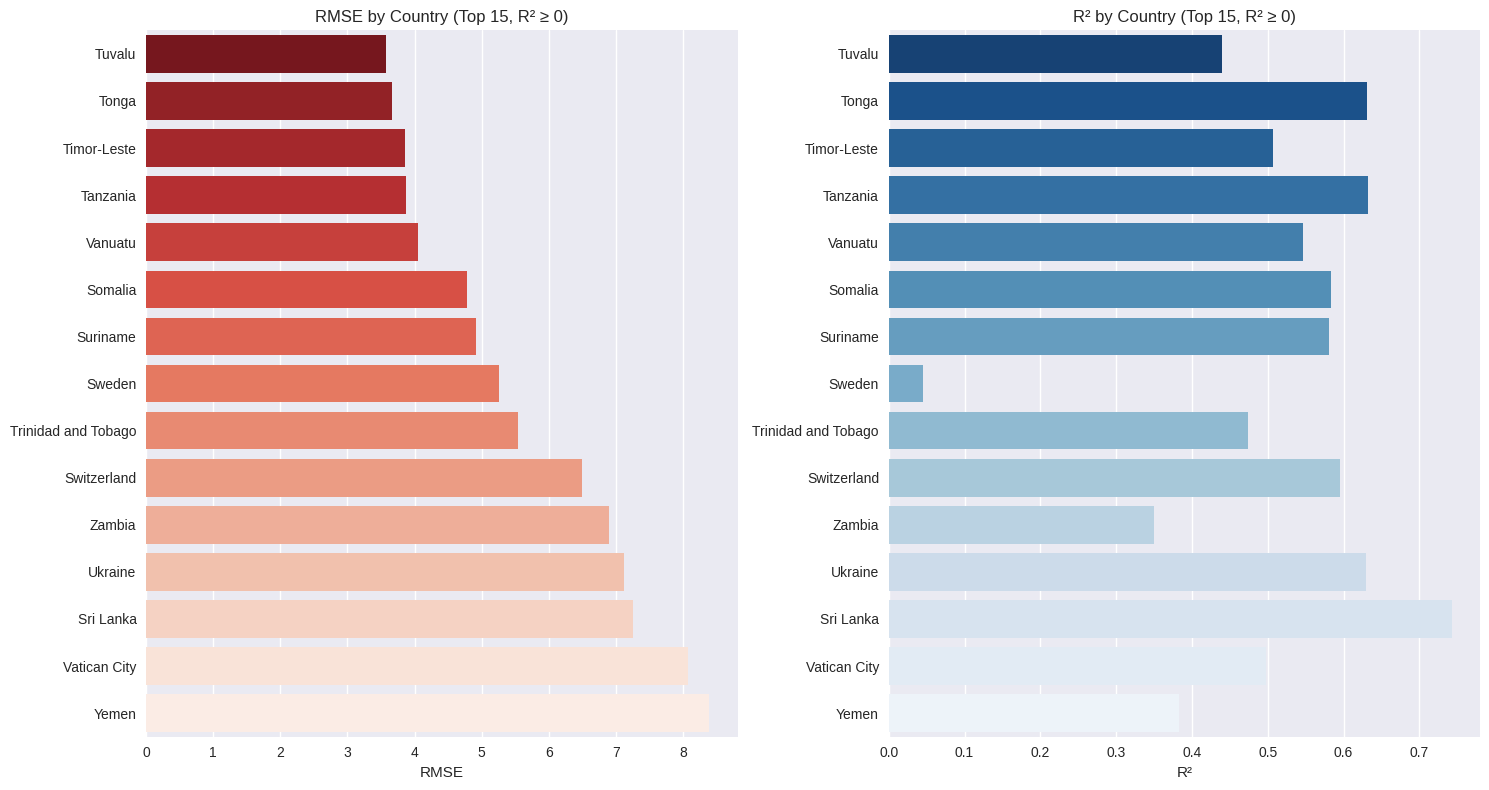

In [34]:
# Step 16: Additional Analysis — Geographical Patterns
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

country_performance = []
for country in df_clean['country'].unique():
    mask = (df_clean['country'] == country) & (df_clean.index.isin(X_test.index))
    if mask.sum() > 10:  # Only consider countries with sufficient test data
        # Extract actuals and preds
        country_actual = y_test[df_clean.loc[X_test.index]['country'] == country]
        country_pred = final_predictions[df_clean.loc[X_test.index]['country'] == country]

        if len(country_actual) > 0:
            rmse = np.sqrt(mean_squared_error(country_actual, country_pred))
            r2 = r2_score(country_actual, country_pred)

            # Only include non-negative R² (valid predictive value)
            if r2 >= 0:
                country_performance.append({
                    'Country': country,
                    'Samples': len(country_actual),
                    'RMSE': rmse,
                    'R²': r2,
                    'Avg_PM2.5': country_actual.mean()
                })

# Create dataframe and sort
country_perf_df = (
    pd.DataFrame(country_performance)
    .sort_values('RMSE', ascending=True)
    .reset_index(drop=True)
)

print("Model Performance by Country (R² ≥ 0, Top 10):")
display(country_perf_df.head(10))

# --- Plot ---
plt.figure(figsize=(15, 8))
top_countries = country_perf_df.head(15)

plt.subplot(1, 2, 1)
sns.barplot(data=top_countries, x='RMSE', y='Country', palette='Reds_r')
plt.title('RMSE by Country (Top 15, R² ≥ 0)')
plt.xlabel('RMSE')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.barplot(data=top_countries, x='R²', y='Country', palette='Blues_r')
plt.title('R² by Country (Top 15, R² ≥ 0)')
plt.xlabel('R²')
plt.ylabel('')

plt.tight_layout()
plt.show()
